Binding of cations into POPC membrane
=====

In this notebook I will estimate the binding stochiometry of cations and POPC lipids.

First we import pyemma and check what version we are using.

In [1]:
from __future__ import print_function
import pyemma


Now we import a few general packages, including basic numerics and algebra routines (numpy) and plotting routines (matplotlib), and makes sure that all plots are shown inside the notebook rather than in a separate window (nicer that way).

In [2]:
import os
%pylab inline
matplotlib.rcParams.update({'font.size': 12})

Populating the interactive namespace from numpy and matplotlib


Now we import the PyEMMA, mdtraj and MDAnalysis modules required for the following steps.

In [3]:
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt

import MDAnalysis as mda
import mdtraj as mdt

/usr/lib64/python2.7/site-packages/pyemma/__init__.py:108: UserWarning: You are not using the latest release of PyEMMA. Latest is 2.4, you have 2.3.
  .format(latest=latest, current=current), category=UserWarning)


Load coordinates and select features
------

We first have to load the PDB file and the trajectory data.
In this section I specify the input files and what metrics (i.e. distances in this case) to measure -- those are called "features" in PyEMMA. I will use this framework to get the distances computed and I will apply some sorting to them later on...

In [4]:
indir = './NpT/sim22a_978mM_NaCl_SPCE_non-tail-atoms_q-sc_0.80_sig-sc_0.89/'
topfile =  indir+'/conf_init.gro'
from glob import glob
traj_list = glob(indir+'/traj_comp.xtc')

We can decide here which features we would like to use in the further analysis. In this case I select all distances between each calcium and Oxygen atoms in POPC. 

In [5]:
feat = coor.featurizer(topfile)
#feat.add_contacts(indices=feat.select("name P31"), indices2=feat.select("index 17152"), count_contacts=True)
#feat.add_contacts(indices=feat.select("name P31"), indices2=feat.select("index 17153"), count_contacts=True)
#feat.add_contacts(indices=feat.select("name P31"), indices2=feat.select("index 17154"), count_contacts=True)
#feat.add_contacts(indices=feat.select("name P31"), indices2=feat.select("index 17155"), count_contacts=True)
#groups_p = feat.select("name P31")
#groups_ca = feat.select("resname CA")
#groups_ca = feat.select("index 17153")
#groups = np.split(np.append(groups_ca, groups_p), range(1,1+groups_ca.shape[0]) )

#pairs = [ [a,groups_ca.shape[0]] for a in range(groups_ca.shape[0])]

#feat.add_group_mindist(groups, np.array(pairs))

#feat.describe()

#feat.add_distances
#feat.add_distances(feat.pairs(feat.select_Heavy()))
# describe the features
# feat.describe()

Get the names, idices and the total number of selected atoms pear each residue

In [6]:
res = feat.topology.residue(0)
n_at_per_res = 0
print("Will select atoms:")
for a in res.atoms:
    if a.name.startswith("O"):
        print(a.index,a.name)
        n_at_per_res += 1
        
print("No. selected atoms per residue = {}".format(n_at_per_res))

Will select atoms:
47 O12
48 O11
57 O31
59 O32
79 O33
80 O34
81 O21
83 O22
No. selected atoms per residue = 8


In [7]:
top = feat.topology
cations = top.select('resname NA')
memb_sites = top.select("name =~ 'O[1-3][1-4]'")
pairs = [ [cat, oxy] for cat in cations for oxy in memb_sites ]
feat.add_distances(pairs)

feat.describe()

['DIST: NA 6361 NA 35848 - POPC 1 O12 47',
 'DIST: NA 6361 NA 35848 - POPC 1 O11 48',
 'DIST: NA 6361 NA 35848 - POPC 1 O31 57',
 'DIST: NA 6361 NA 35848 - POPC 1 O32 59',
 'DIST: NA 6361 NA 35848 - POPC 1 O33 79',
 'DIST: NA 6361 NA 35848 - POPC 1 O34 80',
 'DIST: NA 6361 NA 35848 - POPC 1 O21 81',
 'DIST: NA 6361 NA 35848 - POPC 1 O22 83',
 'DIST: NA 6361 NA 35848 - POPC 2 O12 181',
 'DIST: NA 6361 NA 35848 - POPC 2 O11 182',
 'DIST: NA 6361 NA 35848 - POPC 2 O31 191',
 'DIST: NA 6361 NA 35848 - POPC 2 O32 193',
 'DIST: NA 6361 NA 35848 - POPC 2 O33 213',
 'DIST: NA 6361 NA 35848 - POPC 2 O34 214',
 'DIST: NA 6361 NA 35848 - POPC 2 O21 215',
 'DIST: NA 6361 NA 35848 - POPC 2 O22 217',
 'DIST: NA 6361 NA 35848 - POPC 3 O12 315',
 'DIST: NA 6361 NA 35848 - POPC 3 O11 316',
 'DIST: NA 6361 NA 35848 - POPC 3 O31 325',
 'DIST: NA 6361 NA 35848 - POPC 3 O32 327',
 'DIST: NA 6361 NA 35848 - POPC 3 O33 347',
 'DIST: NA 6361 NA 35848 - POPC 3 O34 348',
 'DIST: NA 6361 NA 35848 - POPC 3 O21 34

In [8]:
feat.dimension()

112640

Now we define the source of input coordinates (we don't load them into memory at this stage - they will be loaded as needed). Compute a few basic data statistics gives:

In [9]:
inp = coor.source(traj_list, feat)
print('number of trajectories = ',inp.number_of_trajectories())
print('trajectory length = ',inp.trajectory_length(0))
#print('trajectory time step = ',500.0 / (inp.trajectory_length(0)-1),'ns')
print('number of dimension = ',inp.dimension())

number of trajectories =  1
trajectory length =  11412
number of dimension =  112640


In [10]:
Y = inp.get_output() # get tica coordinates
print('number of trajectories = ', np.shape(Y)[0])
print('number of frames = ', np.shape(Y)[1])
print('number of dimensions = ',np.shape(Y)[2])

number of trajectories =  1
number of frames =  11412
number of dimensions =  112640


Now, I split the trajectory Y into separate individual trajectories of each individual calcium

In [11]:
Y = np.split(Y[0], cations.shape[0], axis=1)

Split the separate trajectories in Y into residue-based-blocks

In [12]:
for i in range(len(Y)):
    Y[i] = np.reshape(Y[i], [Y[i].shape[0], Y[i].shape[1]/n_at_per_res, n_at_per_res])


Is there a contact per each cation and each individual lipid?

In [13]:
# 1st g(r) depression (after 1st peak) is at 0.28nm -- 0.3nm is a good cut-off distance
# next g(r) depression is at 0.525nm and after that 0.8nm -- there are small peaks in between these two
real_cutoff=0.3
trajs = []
group = 'all'
# for each cation
for i,traj in enumerate(Y):
    print("Working on traj {}".format(i))
    #frames = np.split(traj, traj.shape[0])
    if group=='all':
        # all oxygen atoms in POPC
        frames_ana = np.any(traj[:,:,:]<real_cutoff, axis=-1)
    elif group=='phosphate':
        # only PO4 oxygen atoms in POPC
        frames_ana = np.any(traj[:,:,2:6]<real_cutoff, axis=-1)
    elif group=='carbonyl':
        # only carbonyl oxygen atoms in POPC
        mask = np.ones([8,], dtype=bool)
        mask[2:6] = False
        frames_ana = np.any(traj[:,:,mask]<real_cutoff, axis=-1)
    else:
        raise UserWarning, "undefined group >>{}<< provided".format(group)
    trajs.append(frames_ana)
        

Working on traj 0
Working on traj 1
Working on traj 2
Working on traj 3
Working on traj 4
Working on traj 5
Working on traj 6
Working on traj 7
Working on traj 8
Working on traj 9
Working on traj 10
Working on traj 11
Working on traj 12
Working on traj 13
Working on traj 14
Working on traj 15
Working on traj 16
Working on traj 17
Working on traj 18
Working on traj 19
Working on traj 20
Working on traj 21
Working on traj 22
Working on traj 23
Working on traj 24
Working on traj 25
Working on traj 26
Working on traj 27
Working on traj 28
Working on traj 29
Working on traj 30
Working on traj 31
Working on traj 32
Working on traj 33
Working on traj 34
Working on traj 35
Working on traj 36
Working on traj 37
Working on traj 38
Working on traj 39
Working on traj 40
Working on traj 41
Working on traj 42
Working on traj 43
Working on traj 44
Working on traj 45
Working on traj 46
Working on traj 47
Working on traj 48
Working on traj 49
Working on traj 50
Working on traj 51
Working on traj 52
Wor

Convert individual trajcetories "trajs" into one large array back again:

In [14]:
contacts = np.stack(trajs)

In [15]:
print("tot no. contacts -- no. bound cations -- no. lipids bound to cation(s) -- stoichiometry")
print("---------------------------------------------------------------------------------------")
for i in range(1,1000,100):
    n_bound_cations = contacts[:,i,:].any(axis=-1).sum()
    n_bound_lipids  = contacts[:,i,:].any(axis=0).sum()
    stoichiometry = 1.0*n_bound_lipids/n_bound_cations
    print("{:3d} {:3d} {:3d} {:5.1f}".format(
            contacts[:,i,:].sum(), 
            n_bound_cations, 
            n_bound_lipids,
            stoichiometry
          ))

tot no. contacts -- no. bound cations -- no. lipids bound to cation(s) -- stoichiometry
---------------------------------------------------------------------------------------
 15  10  13   1.3
 17  13  16   1.2
 15  12  15   1.2
 13  11  13   1.2
 23  17  21   1.2
 23  18  23   1.3
 17  13  17   1.3
 11   9  11   1.2
 18  11  17   1.5
 17  11  17   1.5


In [16]:
stoichiometries = np.empty(shape=(contacts.shape[1]))
for i in range(contacts.shape[1]):
    n_bound_cations = contacts[:,i,:].any(axis=-1).sum()
    n_bound_lipids  = contacts[:,i,:].any(axis=0).sum()
    if n_bound_cations==0.0:
        stoichiometries[i] = 0.0
    else:
        stoichiometries[i] = 1.0*n_bound_lipids/n_bound_cations


In [17]:
print("Average stoichiometry of cation-lipid binding = {:5.2f}".format(stoichiometries.mean()))

Average stoichiometry of cation-lipid binding =  1.29


In [18]:
n_bound_cations_per_lipid = np.empty(shape=(contacts.shape[1], contacts.shape[2]), dtype=int)  # per lipid
n_bound_lipids_per_cation = np.empty(shape=(contacts.shape[1], contacts.shape[0]), dtype=int)  # per cation
for i in range(contacts.shape[1]):
    for ica in range(contacts.shape[0]):
        n_bound_lipids_per_cation[i,ica]  = contacts[ica,i,:].sum()
    for ilip in range(contacts.shape[2]):
        n_bound_cations_per_lipid[i,ilip] = contacts[:,i,ilip].sum()

Histogram of no. of bound cations per lipid

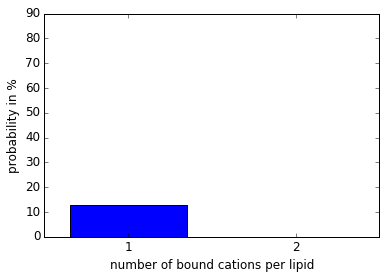

In [19]:
hist_cat_per_lip = np.histogram(n_bound_cations_per_lipid, bins=(0,1,2,3,4))
plt.bar(hist_cat_per_lip[1][:-1]-0.35, 100*hist_cat_per_lip[0]/n_bound_cations_per_lipid.size, width=0.7)#, hist_cat_per_lip[0])
#np.histogram(n_bound_lipids_per_cation, bins=(0,1,2,3,4,5))
plt.xlim([1-0.5,3-0.5])
plt.xticks([1,2])
plt.xlabel("number of bound cations per lipid")
plt.ylabel("probability in %")
plt.savefig("number_bound_cat_p_lipid_Ecc-lipids.eps")

Histogram of no. of bound lipids per cation

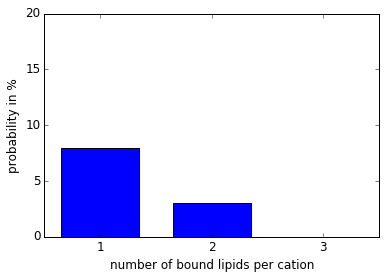

In [20]:
hist_lip_per_cat = np.histogram(n_bound_lipids_per_cation, bins=(0,1,2,3,4))
plt.bar(hist_lip_per_cat[1][:-1]-0.35, 100*hist_lip_per_cat[0]/n_bound_lipids_per_cation.size, width=0.7)#, hist_cat_per_lip[0])
#np.histogram(n_bound_lipids_per_cation, bins=(0,1,2,3,4,5))
plt.xlim([1-0.5,4-0.5])
plt.xticks([1,2,3])
plt.xlabel("number of bound lipids per cation")
plt.ylabel("probability in %")
plt.ylim([0,20])
plt.savefig("number_bound_lipids_p_cation_Ecc-lipids.eps")

In [21]:
# average number of cations, no double counting when a cation binds 2 lipids
n_bound_cations_avg = np.extract(n_bound_lipids_per_cation, n_bound_lipids_per_cation>0).shape[0]*1.0/n_bound_lipids_per_cation.shape[0]
print("Group: {}\nAverage number of bound cations = {:5.1f}\nper lipid = {:5.3f}".format(group, n_bound_cations_avg, n_bound_cations_avg/128.0))

Group: all
Average number of bound cations =  14.2
per lipid = 0.111


In [22]:
import pickle

In [23]:
with open("lipids-per-cation_NaCl_1M.pickle", "w") as f: pickle.dump(hist_lip_per_cat, f)

Now, let's get an estimate of a mean residence time:
frame time step is 20 ps = 0.02 ns

In [24]:
#icat = 0
bound_times = []
time_bound = 0
for icat in range(n_bound_cations_per_lipid.shape[1]):
    cat_traj_temp = n_bound_cations_per_lipid[:,icat]
    for i in range(1, cat_traj_temp.shape[0]):
        if cat_traj_temp[i]>=1:
            if cat_traj_temp[i-1]>=1:
                time_bound += 1
            else:
                time_bound = 1
        else:
            if cat_traj_temp[i-1]>=1:
                bound_times.append(time_bound)
                time_bound = 0

    # last "unfinished" residence time that is still bound at the end of the simulation            
    bound_times.append(time_bound)
    time_bound = 0


In [25]:
bound_times.sort()
print("median: {}".format(np.median(bound_times)))
time_total = np.sum(bound_times)

median: 3.0


In [26]:
cut = -230
frame_dt = 0.02 # 0.02ns=20ps
print([ t*frame_dt for t in bound_times[cut:] ])
fraction_events = 1.0*np.sum(bound_times[:cut])/time_total
print("{:3.0f}% of bound residence time is smaller than {:3.0f} ns, \nThe longest is {:3.0f} ns".format(
        fraction_events*100.0, bound_times[cut]*frame_dt,  bound_times[-1]*frame_dt))


[1.3, 1.3, 1.32, 1.32, 1.32, 1.32, 1.32, 1.32, 1.32, 1.32, 1.32, 1.32, 1.34, 1.34, 1.34, 1.34, 1.34, 1.34, 1.34, 1.34, 1.34, 1.34, 1.36, 1.36, 1.36, 1.36, 1.36, 1.36, 1.36, 1.36, 1.36, 1.36, 1.36, 1.36, 1.36, 1.36, 1.3800000000000001, 1.3800000000000001, 1.3800000000000001, 1.3800000000000001, 1.4000000000000001, 1.4000000000000001, 1.4000000000000001, 1.4000000000000001, 1.4000000000000001, 1.4000000000000001, 1.4000000000000001, 1.4000000000000001, 1.4000000000000001, 1.4000000000000001, 1.4000000000000001, 1.4000000000000001, 1.42, 1.42, 1.42, 1.42, 1.42, 1.42, 1.42, 1.44, 1.44, 1.44, 1.44, 1.44, 1.44, 1.44, 1.46, 1.46, 1.46, 1.46, 1.48, 1.48, 1.48, 1.48, 1.48, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.52, 1.52, 1.52, 1.52, 1.54, 1.54, 1.54, 1.56, 1.56, 1.56, 1.56, 1.56, 1.58, 1.58, 1.58, 1.58, 1.58, 1.58, 1.6, 1.6, 1.6, 1.6, 1.6, 1.62, 1.62, 1.62, 1.62, 1.6400000000000001, 1.6400000000000001, 1.6400000000000001, 1.6400000000000001, 1.6400000000000001, 1.6400000000000001, 

(array([  1.13000000e+02,   7.85800000e+03,   0.00000000e+00,
          3.60100000e+03,   2.58100000e+03,   0.00000000e+00,
          1.99000000e+03,   0.00000000e+00,   1.55600000e+03,
          1.19500000e+03,   0.00000000e+00,   9.96000000e+02,
          0.00000000e+00,   8.54000000e+02,   7.37000000e+02,
          0.00000000e+00,   6.24000000e+02,   0.00000000e+00,
          5.38000000e+02,   4.74000000e+02,   0.00000000e+00,
          3.94000000e+02,   0.00000000e+00,   3.57000000e+02,
          2.80000000e+02,   0.00000000e+00,   2.75000000e+02,
          0.00000000e+00,   2.29000000e+02,   1.79000000e+02,
          0.00000000e+00,   1.85000000e+02,   0.00000000e+00,
          1.85000000e+02,   1.63000000e+02,   0.00000000e+00,
          1.71000000e+02,   0.00000000e+00,   1.19000000e+02,
          1.12000000e+02,   0.00000000e+00,   1.35000000e+02,
          0.00000000e+00,   8.60000000e+01,   8.00000000e+01,
          0.00000000e+00,   8.40000000e+01,   0.00000000e+00,
        

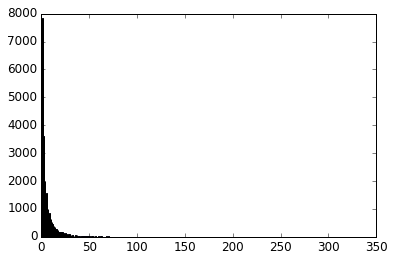

In [27]:
plt.hist(bound_times, bins=500)